In [ ]:
pip install xgboost

In [2]:
import csv
import random
import numpy as np
import datetime as dt
import zipfile

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier


def combined_csv_to_lists(csv_path):
    """
    Parameters
    ----------
    csv_path : str
        Path to the combined CSV with columns:
        comment, timestamp, day, hour, viral

    Returns
    -------
    comments   : list[str]
    timestamps : list[int]
    days       : list[int]
    hours      : list[int]
    labels     : list[int]
    """
    comments = []
    timestamps = []
    days = []
    hours = []
    labels = []

    with open(csv_path, "r", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)

        for row in reader:
            try:
                comment = row["comment"].strip()
                ts = int(row["timestamp"])
                day = int(row["day"])
                hour = int(row["hour"])
                label = int(row["viral"])
            except (KeyError, ValueError):
                # skip rows with missing/invalid data
                continue

            comments.append(comment)
            timestamps.append(ts)
            days.append(day)
            hours.append(hour)
            labels.append(label)

    return comments, timestamps, days, hours, labels


texts, _, _, _, labels = combined_csv_to_lists('dataset.csv')

# Convert everything to numpy arrays (except texts, which stay as list of strings)
y = np.array(labels, dtype=int)

# texts remains a list[str], which is what TfidfVectorizer expects

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [4]:
vectorizer = TfidfVectorizer(
    max_features=50000,      # cap vocab size
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=2,                # ignore words that appear only once
    stop_words=None
)

X_train_sparse = vectorizer.fit_transform(X_train)
X_test_sparse = vectorizer.transform(X_test)

In [5]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality reduction: TF-IDF -> 200 dense components
svd = TruncatedSVD(
    n_components=200,
    random_state=42
)

X_train = svd.fit_transform(X_train_sparse)
X_test = svd.transform(X_test_sparse)

print("Original TF-IDF shape:", X_train_sparse.shape)
print("Reduced SVD shape:", X_train.shape)

Original TF-IDF shape: (90602, 50000)
Reduced SVD shape: (90602, 200)


In [13]:
# RANDOMIZED SEARCH FOR XGBOOST USING F1

!pip install xgboost > /dev/null

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

# Base XGBoost model
base_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist',
    use_label_encoder=False
)

# Parameter search space (tweaked)
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
base_ratio = n_neg / n_pos if n_pos > 0 else 1.0

scale_multipliers = [0.5, 0.6, 0.75, 0.9, 1.1]

param_distributions = {
    "n_estimators":      [250, 350, 500, 650],
    "max_depth":         [3, 4, 5, 6],
    "learning_rate":     [0.03, 0.05, 0.07, 0.10],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.6, 0.7, 0.8, 0.9],
    "min_child_weight":  [3, 5, 7, 10],
    "gamma":             [0.0, 0.5, 1.0, 2.0],
    "scale_pos_weight": [base_ratio * f for f in scale_multipliers],
    "reg_lambda": [0.0, 0.2, 0.5, 1.0, 2.0],
    "reg_alpha":  [0.0, 0.1, 0.3, 0.5],
}

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',   # optimize F1 for the positive class
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

print("Running RandomizedSearchCV with F1...\n")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print("\nBest Parameters Found")
print(random_search.best_params_)

# Evaluate default threshold (0.5)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\nTraining Performance (threshold = 0.5)")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=3))

print("\nTest Performance (threshold = 0.5)")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

print("\nConfusion matrix (test, threshold = 0.5):")
print(confusion_matrix(y_test, y_test_pred))

# Threshold sweep: trade recall vs accuracy
#   (include thresholds above 0.5)
print("\nThreshold sweep on test set ")

y_test_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = [0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70]

for thresh in thresholds:
    y_test_pred_t = (y_test_proba > thresh).astype(int)
    acc = accuracy_score(y_test, y_test_pred_t)
    bal_acc = balanced_accuracy_score(y_test, y_test_pred_t)
    print(f"\n--- Threshold = {thresh:.2f} ---")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print(classification_report(y_test, y_test_pred_t, digits=3))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_test_pred_t))

Running RandomizedSearchCV with F1...

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:02:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Best Parameters Found
{'subsample': 0.9, 'scale_pos_weight': np.float64(3.7500993377483445), 'reg_lambda': 2.0, 'reg_alpha': 0.3, 'n_estimators': 650, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}

 Training Performance (threshold = 0.5)
Accuracy: 0.8496059689631575
Balanced accuracy: 0.8468761460816528
              precision    recall  f1-score   support

           0      0.964     0.851     0.904     75502
           1      0.531     0.843     0.651     15100

    accuracy                          0.850     90602
   macro avg      0.748     0.847     0.778     90602
weighted avg      0.892     0.850     0.862     90602


 Test Performance (threshold = 0.5)
Accuracy: 0.8189801699716713
Balanced accuracy: 0.7940460892513461
              precision    recall  f1-score   support

           0      0.945     0.831     0.884     32358
           1      0.473     0.757     0.582      6472

    accuracy                          0.819 

[0]	validation_0-logloss:0.59648	validation_1-logloss:0.59670
[1]	validation_0-logloss:0.58585	validation_1-logloss:0.58608


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [22:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[2]	validation_0-logloss:0.57752	validation_1-logloss:0.57808
[3]	validation_0-logloss:0.57067	validation_1-logloss:0.57142
[4]	validation_0-logloss:0.56410	validation_1-logloss:0.56517
[5]	validation_0-logloss:0.55840	validation_1-logloss:0.55993
[6]	validation_0-logloss:0.55258	validation_1-logloss:0.55427
[7]	validation_0-logloss:0.54726	validation_1-logloss:0.54917
[8]	validation_0-logloss:0.54301	validation_1-logloss:0.54521
[9]	validation_0-logloss:0.53899	validation_1-logloss:0.54131
[10]	validation_0-logloss:0.53499	validation_1-logloss:0.53749
[11]	validation_0-logloss:0.53163	validation_1-logloss:0.53434
[12]	validation_0-logloss:0.52793	validation_1-logloss:0.53098
[13]	validation_0-logloss:0.52519	validation_1-logloss:0.52838
[14]	validation_0-logloss:0.52207	validation_1-logloss:0.52549
[15]	validation_0-logloss:0.51954	validation_1-logloss:0.52305
[16]	validation_0-logloss:0.51718	validation_1-logloss:0.52084
[17]	validation_0-logloss:0.51465	validation_1-logloss:0.51842


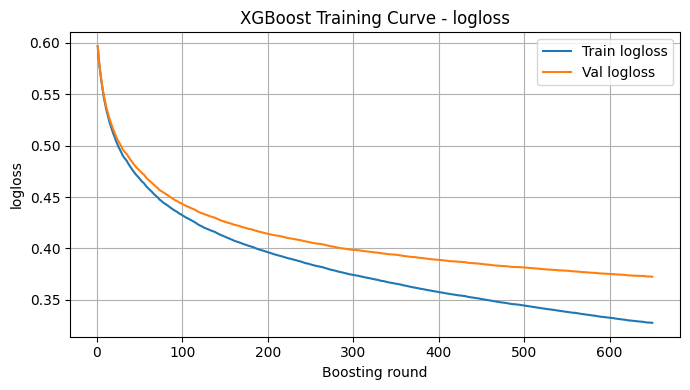

In [20]:
# XGBOOST TRAINING CURVES FOR best_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Start from all sklearn-level params so we keep n_jobs, tree_method, etc.
params = best_model.get_params()

# Ensure eval_metric + early_stopping_rounds are set in the constructor
params["eval_metric"] = "logloss"
params["early_stopping_rounds"] = 20  # patience for early stopping

# params["n_estimators"] = min(params["n_estimators"], 200)

# Make a validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

# Rebuild the model with curve-friendly settings
model_for_curves = XGBClassifier(**params)

# Fit with eval_set (NO early_stopping_rounds or eval_metric in .fit())
model_for_curves.fit(
    X_tr,
    y_tr,
    eval_set=eval_set,
    verbose=True,
)

# Grab training history
results = model_for_curves.evals_result()

# Plot function
def plot_training_curves(results, metric="logloss"):
    train_metric = results["validation_0"][metric]
    val_metric   = results["validation_1"][metric]
    rounds = range(1, len(train_metric) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(rounds, train_metric, label=f"Train {metric}")
    plt.plot(rounds, val_metric,   label=f"Val {metric}")
    plt.xlabel("Boosting round")
    plt.ylabel(metric)
    plt.title(f"XGBoost Training Curve - {metric}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot logloss curve
plot_training_curves(results, metric="logloss")

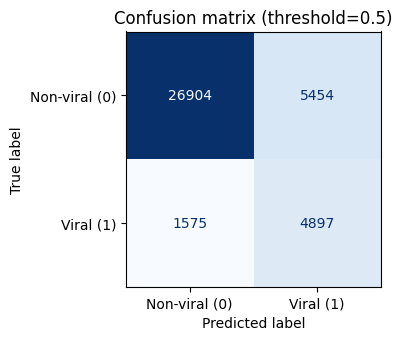

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-viral (0)", "Viral (1)"]
    )
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# usage (test set for a given threshold)
plot_confusion(y_test, y_test_pred, title="Confusion matrix (threshold=0.5)")

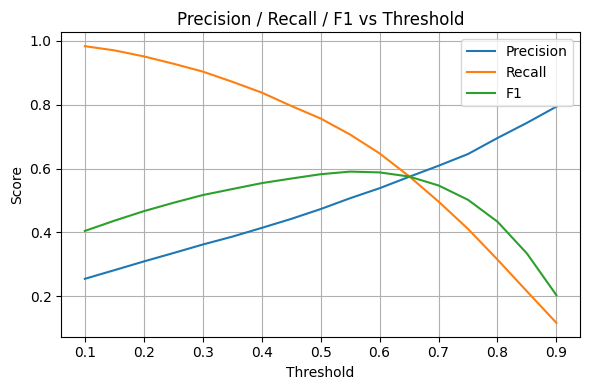

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 17)  # 0.10, 0.15, …, 0.90
    precisions = []
    recalls = []
    f1s = []

    for th in thresholds:
        y_pred = (y_proba >= th).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    plt.figure(figsize=(6,4))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls,   label="Recall")
    plt.plot(thresholds, f1s,       label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# usage
y_test_proba = best_model.predict_proba(X_test)[:, 1]
plot_metrics_vs_threshold(y_test, y_test_proba)

In [23]:
# Save the best model to a file
best_model.save_model("best_model.json")
print("Saved best_model to best_model.json")

Saved best_model to best_model.json


In [24]:
from xgboost import XGBClassifier

loaded_model = XGBClassifier()
loaded_model.load_model("best_model.json")

# Example usage:
loaded_model.predict(X_test)

array([1, 0, 1, ..., 0, 0, 0])